In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Problem
Đây là bài toán hồi quy tuyến tính (Regression)

Bộ dữ liệu này gồm 506 dữ liệu với 14 cột.

Đó là các trường sau:
1. CRIM: tỉ lệ tội phạm bình quan theo đầu người theo thị trấn 
2. ZN: tỷ lệ đất được quy hoach cho các lô đất trên 25000 sq.ft
3. INDUS: tỷ lệ mẫu đất kinh doanh không bán lẻ trên mỗi thị trấn
4. CHAOS: Biến giả Charles River (= 1 nếu đường bao quanh sông; 0 nếu ngược lại)
5. NOX: nồng độ oxit nitric (phần trên 10 triệu)
6. RM: số lượng phòng trung bình trên một ngôi nhà
7. AGE: tỷ lệ các căn hộ có chủ sở hữu được xây dựng trước năm 1940
8. DIS: khoảng cách có trọng số đến năm trung tâm việc làm Boston
9. RAD: chỉ số khả năng tiếp cận các đường cao tốc hướng tâm
10. TAX: thuế suất tài sản toàn giá trị trên $ 10.000
11. PTRATIO: tỷ lệ học sinh-giáo viên theo thị trấn
12. B: 1000 (Bk - 0,63) ^ 2 trong đó Bk là tỷ lệ người da đen theo thị trấn
13. LSTAT: \% tình trạng dân số thấp
14. MEDV: Giá trị trung bình của những ngôi nhà có chủ sở hữu tính bằng \$ 1000

## Target
Dự đoán giá trị trung bình của những ngôi nhà có chủ sở hữu (MEDV)

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import StandardScaler, RobustScaler

In [5]:
data_dir = "/content/drive/MyDrive/Teaching Assistant BKHN/week1/data/housing.csv"

In [6]:
# Tạo bảng với các cột và xem qua 5 samples
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
house_data = pd.read_csv(data_dir, header=None, delimiter=r"\s+", names=column_names)
house_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [7]:
# Bắt đầu tìm hiểu về các trường dữ liệu (verbose: hiển thị thông tin của các trường dữ liệu)
house_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [8]:
# Tìm hiểu về các giá trị của từng trường dữ liệu là số
house_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [11]:
seed = 8
X_train, X_test, y_train, y_test = train_test_split(house_data.drop(["MEDV"], axis = 1), house_data["MEDV"], test_size = 0.3, random_state = seed)

In [12]:
train_data = X_train.copy()
train_data["MEDV"] = y_train
test_data = X_test.copy()
test_data["MEDV"] = y_test

train_data.to_csv("train.csv", index = False)
test_data.to_csv("test.csv", index = False)

In [13]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Text(0, 0.5, 'MEDV')

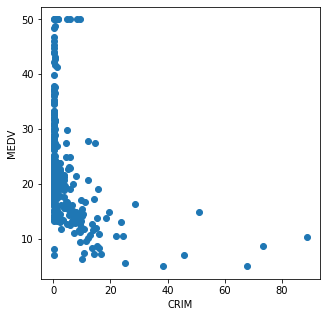

In [14]:
# Điều chỉnh size của ảnh đầu ra trong plt VD: (10, 15) -> chiều rộng 10, chiều dài 15
fig = plt.figure(figsize = (5, 5))
# Sử dụng đồ thị scatter để xem mối quan hệ giữa CRIM vs MEDV
plt.scatter(train_data["CRIM"], train_data["MEDV"])
plt.xlabel("CRIM")
plt.ylabel("MEDV")

**Nhận xét**: 
- CRIM ở đây là tỉ lệ tội phạm bình quân theo đầu người theo thị trấn
- Ta thấy CRIM vs MEDV không có mối quan hệ với nhau 
- Không chỉ thế, ta thấy trường CRIM khá phức tạp trong bộ dữ liệu do đó ta nên khiến nó trở nên đơn giản hơn. 
Chẳng hạn như > 5% là nhiều tội phạm ta cho là 1 còn không ta để là 0 tức là ít tội phạm

Text(0, 0.5, 'MEDV')

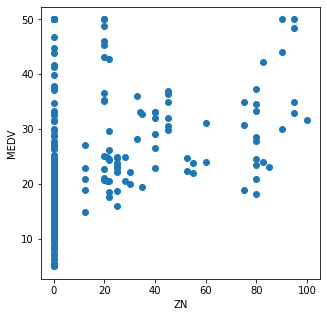

In [15]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa ZN vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["ZN"], train_data["MEDV"])
plt.xlabel("ZN")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

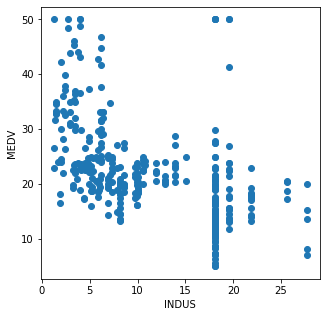

In [16]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa INDUS vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["INDUS"], train_data["MEDV"])
plt.xlabel("INDUS")
plt.ylabel("MEDV")

**Nhận xét**:
- INDUS là tỉ lệ mẫu đất kinh doanh không bán lẻ ở mỗi thị trấn.
- Dựa vào scatter thì ta cx thấy INDUS không có mối quan hệ với MEDV
- Tuy nhiên ta có thể nhận thấy phần lớn thị trấn nào ms có INDUS >= 10 thì giá trị trung bình giá nhà trên thị trấn ý cx nhỏ hơn 30. Vì vậy ta có thể thử làm tương tự cách làm vs CRIM ta có thể đổi nếu INDUS >= 10 thì là số 1 còn lại là 0

Text(0, 0.5, 'MEDV')

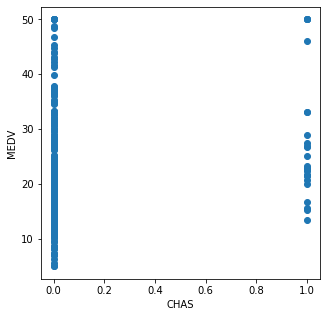

In [17]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa CHAS vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["CHAS"], train_data["MEDV"])
plt.xlabel("CHAS")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

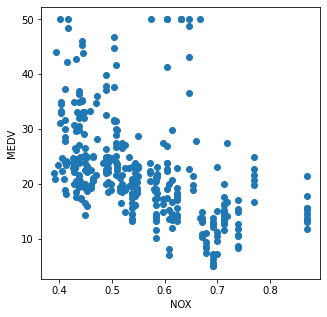

In [18]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa NOX vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["NOX"], train_data["MEDV"])
plt.xlabel("NOX")
plt.ylabel("MEDV")

**Nhận xét**:
- NOX là nồng độ oxit nitric (phần trên 10 triệu) 
- Ta có thể thấy nồng độ này càng cao cụ thể trên hình là xấp xỉ 0.65 đổ lên giá tiền nhà trung bình sẽ thấp

Text(0, 0.5, 'MEDV')

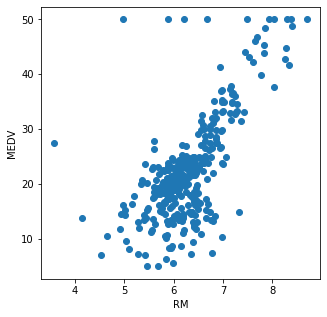

In [19]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa RM vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["RM"], train_data["MEDV"])
plt.xlabel("RM")
plt.ylabel("MEDV")

**Nhận xét:**
- RM là số lượng phòng trung bình trên mỗi ngôi nhà
- Ta có thể thấy trên hình RM vs MEDV có mối quan hệ tuyến tính với nhau 
- Nếu RM tăng thì MEDV tăng

Text(0, 0.5, 'MEDV')

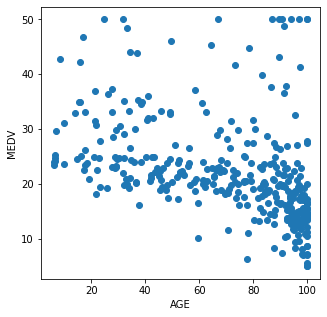

In [20]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa AGE vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["AGE"], train_data["MEDV"])
plt.xlabel("AGE")
plt.ylabel("MEDV")

**Nhận xét:**
- AGE là tỉ lệ căn hộ có chủ sở hữu trc năm 1940.
- Dễ dàng nhận thấy trường này không có mối quan hệ với MEDV.

Text(0, 0.5, 'MEDV')

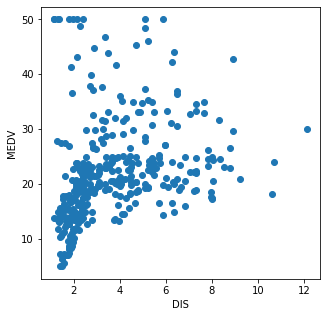

In [21]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa DIS vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["DIS"], train_data["MEDV"])
plt.xlabel("DIS")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

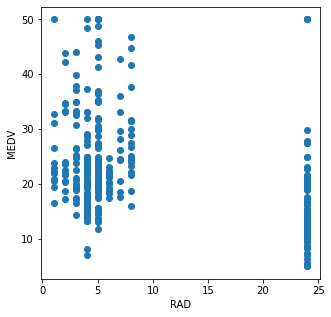

In [22]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa RAD vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["RAD"], train_data["MEDV"])
plt.xlabel("RAD")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

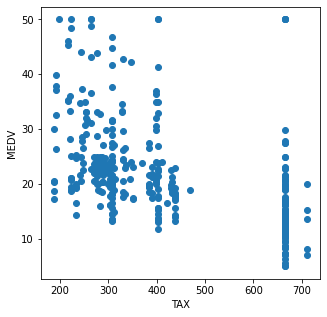

In [23]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa TAX vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["TAX"], train_data["MEDV"])
plt.xlabel("TAX")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

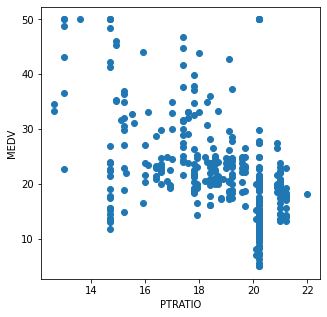

In [24]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa PTRATIO vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["PTRATIO"], train_data["MEDV"])
plt.xlabel("PTRATIO")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

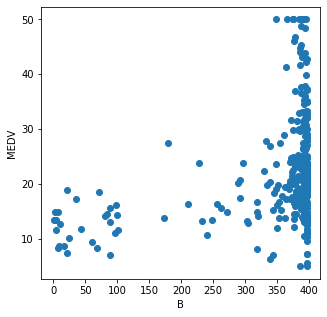

In [25]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa B vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["B"], train_data["MEDV"])
plt.xlabel("B")
plt.ylabel("MEDV")

Text(0, 0.5, 'MEDV')

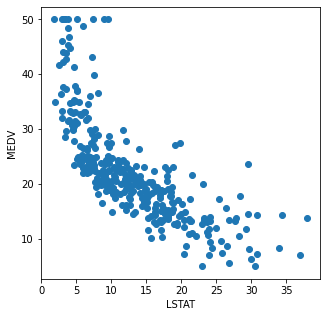

In [26]:
# Sử dụng đồ thị scatter để xem mối quan hệ giữa LSTAT vs MEDV
fig = plt.figure(figsize = (5, 5))
plt.scatter(train_data["LSTAT"], train_data["MEDV"])
plt.xlabel("LSTAT")
plt.ylabel("MEDV")

**Nhận xét:**
- LSTAT LÀ \% tình trạng dân số thấp
- Ta có thể thấy trên hình LSTAT vs MEDV có mối quan hệ tuyến tính với nhau 
- Nếu LSTAT tăng thì MEDV có xu hướng giảm

## Ma trận hệ số tương quan với heatmap
Chúng ta có thể sử dụng hàm heatmap trong seaborn để vẽ ma trận hệ số tương quan giữa các trường trong bảng.

Vậy hệ số tương quan là gì ??? Không nói về mặt tính toán trong toán học.

Hệ số tương quan theo cách hiểu đơn giản là xem xét mối quan hệ giữa hai trường với nhau nếu có giá trị càng gần hai cận 1 hoặc -1 thì giữa chúng nó càng liên quan tuyến tính với nhau.

Cụ thể coi hệ số là a với hai biến ngẫu nhiên là X và Y
- nếu a > 0 thì tương quan thuận
- nếu a < 0 thì tương quan nghịch
- nếu a = 0 thì không có gì hết 
- nếu a = +- 1 thì tương quan tuyến tính như Y = cX + d

Chính vì thế ta có thể dùng ma trận hệ số tương quan này để cắt bỏ bớt 1 số trường không cần thiết.

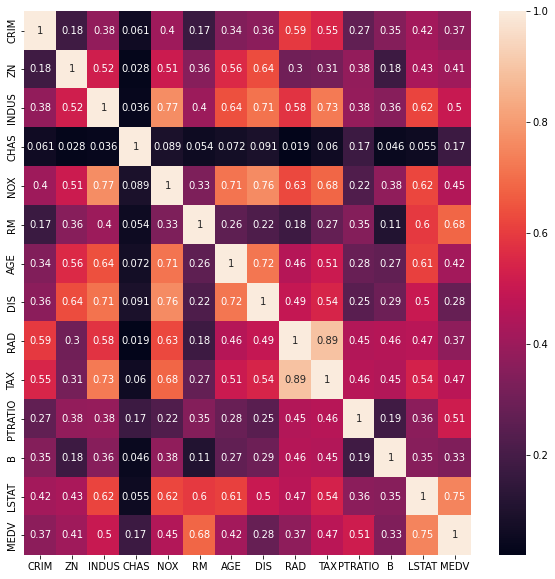

In [27]:
# Lấy correlation value 
plt.figure(figsize = (10, 10))
sns.heatmap(train_data.corr().abs(), annot = True)
plt.show()

In [28]:
def drop_with_high_corr(table, threshold):
    # Lấy giá trị tuyệt đối các giá trị trong bảng
    corr_matrix = table.corr().abs()
    # Tính trung bình hệ số tương quan cho mỗi trường đối với trường còn lại
    avg_corr_matrix = corr_matrix.mean(axis = 1)
    # Tạo ma trận tam giác trên từ corr_matrix 
    up = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # List các cột xóa
    drop_columns = list()

    for row in range(len(up)-1):
        col_idx = row + 1
        # row != col 
        for col in range (col_idx, len(up) - 1):
            if(corr_matrix.iloc[row, col] > threshold):
                # Chọn đặc trưng nào có trung bình hệ số tương quan lớn hơn
                if(avg_corr_matrix.iloc[row] > avg_corr_matrix.iloc[col]): 
                    drop_columns.append(row)
                else: 
                    drop_columns.append(col)
    
    # Dùng set để khiến mỗi phân tử bên trong mảng drop là duy nhất
    drop_set = list(set(drop_columns))
    dropcols_names = list(table.columns[[item for item in drop_set]])
    
    return dropcols_names

### Dữ liệu gốc

In [70]:
# Sử dụng dữ liệu gốc
X, y = train_data.drop(["MEDV"], axis = 1), train_data["MEDV"]
X_test, y_test = test_data.drop(["MEDV"], axis = 1), test_data["MEDV"]
# Chuẩn hóa dữ liệu 
scaler = StandardScaler()
transform = scaler.fit(X)
X = transform.transform(X)
X_test = transform.transform(X_test)

In [71]:
# Sử dụng mô hình Linear Regression
linear = LinearRegression()
linear.fit(X, y)

# Xem kết quả với tập train và test
print("1. Linear Regression")
print("Train MSE linear: %.2f" % mean_squared_error(y, linear.predict(X)))
print("Test MSE linear: %.2f" % mean_squared_error(y_test, linear.predict(X_test)))
print("----------------------------------------------")

# Sử dụng mô hình KNN
knn = KNN()
knn.fit(X, y)

# Xem kết quả với tập train và test
print("2. KNN")
print("Train MSE linear: %.2f" % mean_squared_error(y, knn.predict(X)))
print("Test MSE linear: %.2f" % mean_squared_error(y_test, knn.predict(X_test)))
print("----------------------------------------------")

1. Linear Regression
Train MSE linear: 21.45
Test MSE linear: 23.72
----------------------------------------------
2. KNN
Train MSE linear: 15.60
Test MSE linear: 23.12
----------------------------------------------


### Dữ liệu sau quá trình phân tích

In [72]:
def thresh_func(table, col, threshold):
  new_value = []
  for value in table[col]:
    if value >= threshold:
      new_value.append(1)
    else:
      new_value.append(0)
  return pd.Series(new_value)

In [73]:
# Loại bỏ một số trường không cần thiết
drop_columns = drop_with_high_corr(train_data, 0.8)
print(drop_columns)

trainV2 = train_data.drop(drop_columns, axis = 1)
testV2 = test_data.drop(drop_columns, axis = 1)

['TAX']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [74]:
# CRIM
trainV2["CRIM"] = thresh_func(trainV2, "CRIM", 5)
testV2["CRIM"] = thresh_func(testV2, "CRIM", 5)

# INDUS
trainV2["INDUS"] = thresh_func(trainV2, "INDUS", 10)
testV2["INDUS"] = thresh_func(testV2, "INDUS", 10)

# NOX
trainV2["NOX"] = thresh_func(trainV2, "NOX", 0.65)
testV2["NOX"] = thresh_func(testV2, "NOX", 0.65)

# AGE
trainV2["AGE"] = thresh_func(trainV2, "AGE", 80)
testV2["AGE"] = thresh_func(testV2, "AGE", 80)

X, y = trainV2.drop(["MEDV"], axis = 1), trainV2["MEDV"]
X_test, y_test = testV2.drop(["MEDV"], axis = 1), testV2["MEDV"]
# Normalize dữ liệu 
scaler = StandardScaler()
transform = scaler.fit(X)
X = transform.transform(X)
X_test = transform.transform(X_test)

# Sử dụng mô hình Linear Regression
linear = LinearRegression()
linear.fit(X, y)

# Xem kết quả với tập train và test
print("1. Linear Regression")
print("Train MSE linear: %.2f" % mean_squared_error(y, linear.predict(X)))
print("Test MSE linear: %.2f" % mean_squared_error(y_test, linear.predict(X_test)))
print("----------------------------------------------")

# Sử dụng mô hình KNN
knn = KNN()
knn.fit(X, y)

# Xem kết quả với tập train và test
print("2. KNN")
print("Train MSE linear: %.2f" % mean_squared_error(y, knn.predict(X)))
print("Test MSE linear: %.2f" % mean_squared_error(y_test, knn.predict(X_test)))
print("----------------------------------------------")

1. Linear Regression
Train MSE linear: 21.26
Test MSE linear: 23.98
----------------------------------------------
2. KNN
Train MSE linear: 16.09
Test MSE linear: 18.25
----------------------------------------------


### Thêm 1: Chọn feature bằng sklearn (Forward Feature Selection by sklearn)

In [ ]:
X, y = train_data.drop(["MEDV"], axis = 1), train_data["MEDV"]

In [ ]:
# Lấy một feature xong tăng dần đến khi mô hình đạt tối ưu
from sklearn.feature_selection import f_regression
f_val, p_val = f_regression(X, y)

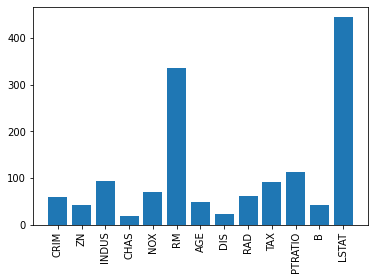

In [ ]:
plt.bar(train_data.drop("MEDV", axis = 1).columns, f_val)
plt.xticks(rotation = 90)
plt.show()

In [35]:
# Top 5 các trường đóng góp nhiều nhất
trainV3 = train_data[["RM", "LSTAT", "PTRATIO", "INDUS", "TAX", "MEDV"]]
testV3 = test_data[["RM", "LSTAT", "PTRATIO", "INDUS", "TAX", "MEDV"]]

X, y = trainV3.drop(["MEDV"], axis = 1), trainV3["MEDV"]
X_test, y_test = testV3.drop(["MEDV"], axis = 1), testV3["MEDV"]

# INDUS
trainV3["INDUS"] = thresh_func(trainV3, "INDUS", 10)
testV3["INDUS"] = thresh_func(testV3, "INDUS", 10)

# Normalize dữ liệu 
scaler = StandardScaler()
transform = scaler.fit(X)
X = transform.transform(X)
X_test = transform.transform(X_test)

# Sử dụng mô hình Linear Regression
linear = LinearRegression()
linear.fit(X, y)

# Xem kết quả với tập train và test
print("1. Linear Regression")
print("Train MSE linear: %.2f" % mean_squared_error(y, linear.predict(X)))
print("Test MSE linear: %.2f" % mean_squared_error(y_test, linear.predict(X_test)))
print("----------------------------------------------")

# Sử dụng mô hình KNN
knn = KNN()
knn.fit(X, y)

# Xem kết quả với tập train và test
print("2. KNN")
print("Train MSE linear: %.2f" % mean_squared_error(y, knn.predict(X)))
print("Test MSE linear: %.2f" % mean_squared_error(y_test, knn.predict(X_test)))
print("----------------------------------------------")

1. Linear Regression
Train MSE linear: 26.08
Test MSE linear: 29.73
----------------------------------------------
2. KNN
Train MSE linear: 11.34
Test MSE linear: 17.14
----------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Bonus 2: Linear and Ridge Regression code by hand

In [ ]:
class MyLinearRegression:

  def __init__(self):
    self.weight = None

  def mse_loss(self, y_true, y_pred):
    return mean_squared_error(y_true, y_pred)
  
  def fit(self, X, y):
    X = X.reshape((X.shape[1], X.shape[0]))
    y = y.to_numpy().reshape((-1, 1))
    self.weight = np.dot(np.linalg.pinv(X.dot(X.T)), X.dot(y))
    return self.weight
  
  def get_weight(self):
    return self.weight

  def predict(self, X):
    X = X.reshape((X.shape[1], X.shape[0]))
    if self.weight is None:
      raise ValueError("You need to fit the model!!!")
    else:
      return X.T.dot(self.weight)
  
  def evaluate(self, X, y):
    if self.weight is None:
      raise ValueError("You need to fit the model!!!")
    return self.mse_loss(y, self.predict(X))

class MyRidgeRegression(MyLinearRegression):

  def __init__(self, lamda):
    super(MyRidgeRegression, self).__init__()
    self.lamda = lamda

  def mse_loss(self, y_true, y_pred):
    return mean_squared_error(y_true, y_pred) + self.lamda*np.sum(self.weight**2)
  
  def fit(self, X, y):
    X = X.reshape((X.shape[1], X.shape[0]))
    y = y.to_numpy().reshape((-1, 1))

    A = X.dot(X.T)
    I = np.eye(A.shape[0], A.shape[1])*self.lamda
    self.weight = np.dot(np.linalg.inv(A + I), X.dot(y))
    return self.get_weight()